In [1]:
from transformations.Compose import Compose
from transformations.BrightnessContrastTransform import BrightnessContrastTransform
from transformations.PerspectiveTransform import PerspectiveTransform
from transformations.Resize import Resize

In [2]:
import glob
import cv2,copy
from PIL import Image, ImageDraw
import numpy as np
import scipy
import random
import math
import json
from shapely.geometry import Polygon

In [3]:
# !wget https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz;tar xf dtd-r1.0.1.tar.gz

### TO DO:
#### Data generation
- [x]  make sure that at least one corner of every card is fully visible
- [x]  return polygon data for generated image
- [ ]  check if size of background is appropriate for the size and number of cards (if the background is too big it will take long to generate image, if it's too small, the cards might overlap)
- [x]  fix rotation of polygons (everything works fine if the cards are not rotated)
- [ ]  remove/clip polygons that do not fit in the image
- [x]  remove label polygons that are obscured by other cards

In [4]:
def imshow(a):
    a = a.clip(0, 255).astype('uint8')
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(a))

In [5]:
def rotate(image, angleInDegrees, point=None):
    h, w = image.shape[:2]
    if not point:
        point = (w / 2, h / 2)

    rot = cv2.getRotationMatrix2D(point, angleInDegrees, 1)

    rad = math.radians(angleInDegrees)
    sin = math.sin(rad)
    cos = math.cos(rad)
    b_w = int((h * abs(sin)) + (w * abs(cos)))
    b_h = int((h * abs(cos)) + (w * abs(sin)))

    rot[0, 2] += ((b_w / 2) - point[0])
    rot[1, 2] += ((b_h / 2) - point[1])

    outImg = cv2.warpAffine(image, rot, (b_w, b_h), flags=cv2.INTER_LINEAR)
    return outImg

In [6]:
def overlay(img, img_overlay, x, y, alpha_mask):
    """Overlay `img_overlay` onto `img` at (x, y) and blend using `alpha_mask`.

    `alpha_mask` must have same HxW as `img_overlay` and values in range [0, 1].
    """
    # Image ranges
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    # Overlay ranges
    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    # Exit if nothing to do
    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    # Blend overlay within the determined ranges
    img_crop = img[y1:y2, x1:x2]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o]
    alpha = alpha_mask[y1o:y2o, x1o:x2o, np.newaxis]
    alpha_inv = 1.0 - alpha

    img_crop[:] = alpha * img_overlay_crop + alpha_inv * img_crop

In [7]:
def check_polygons(card, metadata):
    local_meta = copy.deepcopy(metadata)
    p1 = Polygon(np.array(card['card_polygon']))
    for i in local_meta:
        corners = [Polygon(np.array(corner)) for corner in local_meta[i]['label_polygons']]
        corners = [p1.intersects(p2) or p1.crosses(p2) or p1.contains(p2) for p2 in corners]
        gone = 0
        for count, poly in enumerate(corners):
            if poly:
                if len(local_meta[i]['label_polygons']) == 1:
                    
                    print(i, len(metadata[i]['label_polygons']))
                    return False, metadata
                else:
                    del local_meta[i]['label_polygons'][count-gone]
                    gone += 1
    return True, local_meta

In [8]:
def random_card_generator(cards_paths,n):
    cards = cards_paths.copy()
    random.shuffle(cards)
    for card_path in cards[:n]:
        card = cv2.imread(card_path+".png", -1)
        annots =  json.load(open(card_path+".json",'r'))
        card_polygon = annots['card_polygon']
        label_polygons = annots['label_polygons']
        yield {'image':card,'label_polygons':label_polygons,'card_polygon':card_polygon,'filename':card_path.split("/")[-1]}
        

In [9]:
transforms = Compose([
    PerspectiveTransform(degrees_range=(0, 45)),
    BrightnessContrastTransform(),
    Resize()
])

In [10]:
def numpy_to_list(array):
    lst2 = []
    for i in array:
        lst = []
        for k in i:
            lst.append(float(k))
        lst2.append(lst)
    return lst2

In [11]:
def translate_polygon(polygon,translation):
    return numpy_to_list(np.asarray(polygon) + translation)
    

In [12]:
def generate_random_point(max_y,max_x,card_y,card_x):
    x = random.randint(0, max_x-int(card_x))
    y = random.randint(0, max_y-int(card_y))
    return np.array((x, y))

In [13]:
0.05, 0.15

(0.05, 0.15)

In [14]:
def create_canvas(background, cards_paths, n=10, zoom=0.05):
    coords = []
    metadata = {}
    canvas = background[:, :, :3].copy()
    
    background_shape = canvas.shape[:2]
    
    for card_dict in random_card_generator(cards_paths,n):
        size = np.random.randint(int(0.20*max(background_shape)),int(0.40*max(background_shape)))
        augmented_card = transforms(card_dict,size=size)
        card = augmented_card['image']
        alpha_mask = card[:, :, 3] / 255.0
        card_rgb = card[:, :, :3]
        
        card_shape = card.shape[:2]
        tries = 0
        while(True):
            repeat = False
            random_point = generate_random_point(*background_shape,*card_shape)
            new_card_poly = translate_polygon(augmented_card['card_polygon'],random_point)
            new_label_poly = [translate_polygon(polygon,random_point) for polygon in augmented_card['label_polygons']]
            card_polygons = {'label_polygons':new_label_poly,'card_polygon':new_card_poly}
            polygons_ok, new_meta = check_polygons(card_polygons, metadata)
            if not polygons_ok:
                repeat = True
                tries += 1
            if not repeat:
                coords.append(random_point)
                overlay(canvas, card_rgb, *random_point, alpha_mask)
                metadata[card_dict['filename']] = card_polygons
                break
            if tries > 50:
                break
                
        test = Image.fromarray(canvas) 
        for card_meta in metadata:
            for polygon in  metadata[card_meta]['label_polygons']:
                polygon = [tuple(i) for i in polygon]
                ImageDraw.Draw(test).polygon(polygon,fill=255, outline=255)

            polygon = [tuple(i) for i in metadata[card_meta]['card_polygon']]
            ImageDraw.Draw(test).line(polygon, fill="blue", width=5)
    imshow(np.array(test))
    
    return canvas, metadata

In [15]:
def numpy_to_list(array):
    lst2 = []
    for i in array:
        lst = []
        for k in i:
            lst.append(float(k))
        lst2.append(lst)
    return lst2

In [16]:
change_perspective = PerspectiveTransform()

In [17]:
textures = glob.glob("../dtd/images/*/*.jpg")
cards = glob.glob("../interim_data/*.png")
cards = [f.rstrip(".png") for f in cards]

In [18]:
classes = sorted([card.split("/")[-1] for card in cards],key=lambda x: (x[-1],x[:-1]))

In [19]:
class_to_id = dict(zip(classes,range(len(classes))))

In [20]:
with open("class_mapping.json",'w') as fp:
    json.dump(class_to_id,fp)

In [21]:
def polygon_to_yolo_bbox(polygon,image_shape):
    polygon = np.asarray(polygon)
    x_s,y_s = polygon[:,0],polygon[:,1]
    minX,maxX = x_s[x_s.argsort()][[0,-1]]
    minY,maxY = y_s[y_s.argsort()][[0,-1]]
    x_center = ((minX+maxX)/2)/image_shape[1]
    y_center = ((minY+maxY)/2)/image_shape[0]
    width = abs(minX-maxX)/image_shape[1]
    height = abs(minY-maxY)/image_shape[0]
    return np.float32([x_center,y_center,width,height])

In [22]:
def create_data(image,image_dict,filename):
    with open(filename+".txt",'w+') as fp:
        for card in image_dict:
            for polygon in image_dict[card]['label_polygons']:
                bbox = polygon_to_yolo_bbox(polygon,out.shape)
                fp.write(str(class_to_id[card]) + " "+ " ".join(list(map(str,bbox)))+'\n')
    cv2.imwrite(filename+".jpg",image)

Tried: 11


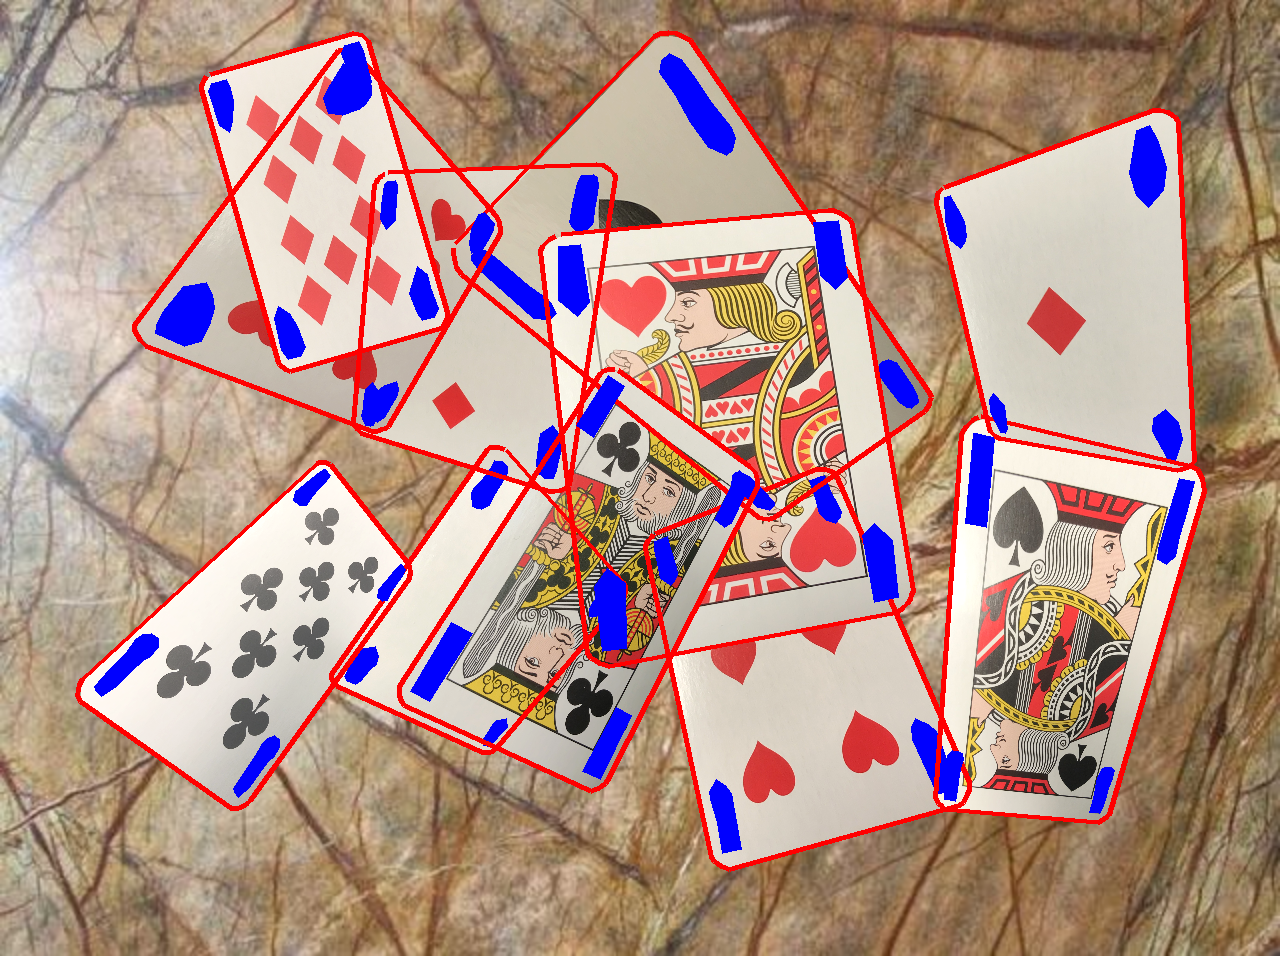

Generated: 11


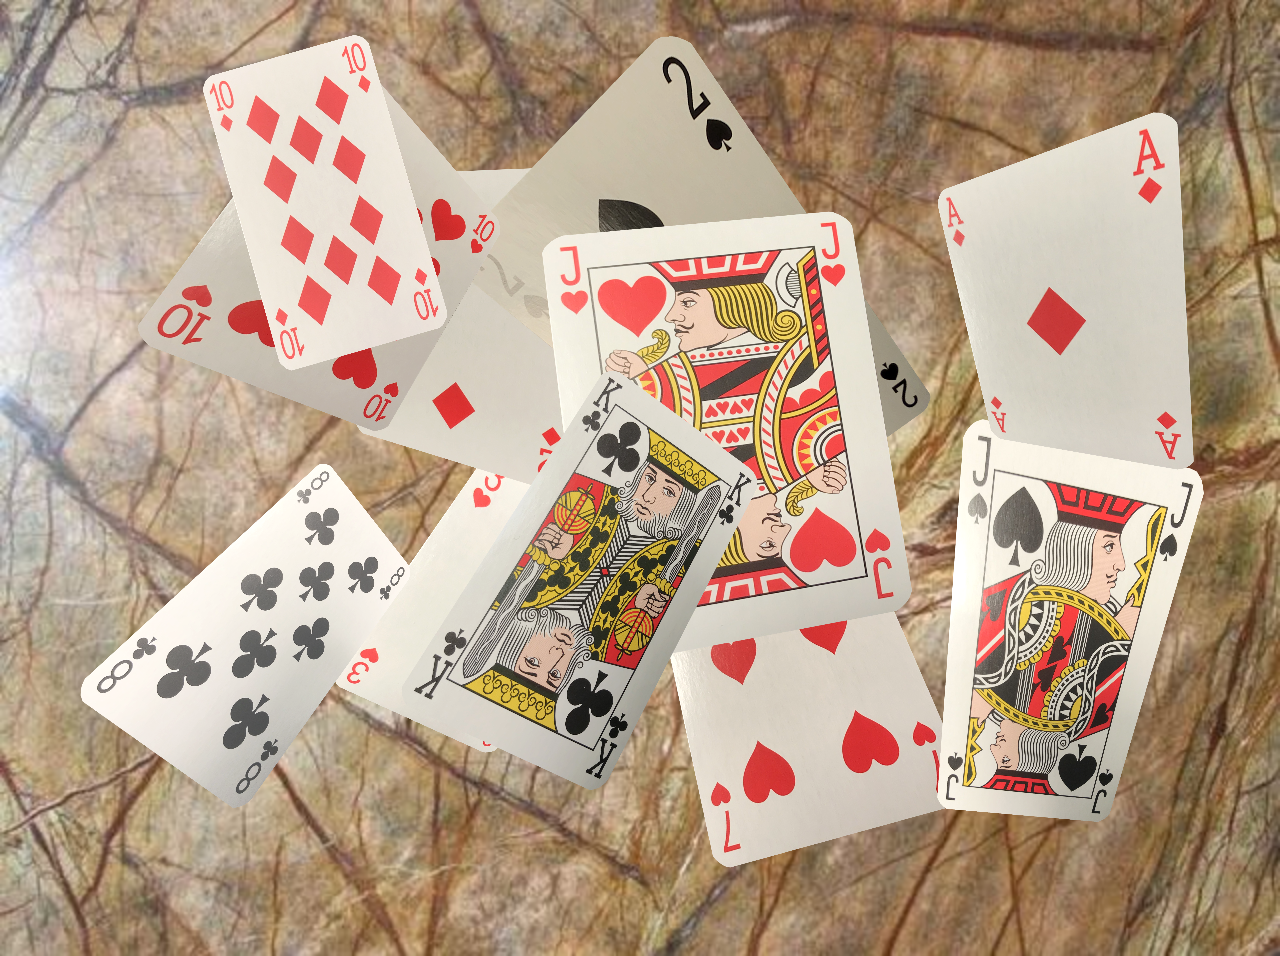

In [28]:
back_path = random.choice(textures)
back = cv2.imread(back_path, -1)
back = cv2.resize(back, None, fx=2, fy=2)
n = random.randint(1, 12)
print(f"Tried: {n}")
out, image_dict = create_canvas(back, cards, n, random.uniform(0.05, 0.15))
print(f"Generated: {len(image_dict)}")
imshow(out)